使用设备：cuda
共加载 5616 张图片，共 3 个类别。
训练集：3369，验证集：1123，测试集：1124
Epoch [1/100], Loss: 1.0423, Val Acc: 54.05%
保存最佳模型！
Epoch [2/100], Loss: 0.8858, Val Acc: 63.94%
保存最佳模型！
Epoch [3/100], Loss: 0.7509, Val Acc: 66.34%
保存最佳模型！
Epoch [4/100], Loss: 0.6586, Val Acc: 71.33%
保存最佳模型！
Epoch [5/100], Loss: 0.5728, Val Acc: 75.42%
保存最佳模型！
Epoch [6/100], Loss: 0.4920, Val Acc: 76.94%
保存最佳模型！
Epoch [7/100], Loss: 0.4265, Val Acc: 80.14%
保存最佳模型！
Epoch [8/100], Loss: 0.3614, Val Acc: 81.57%
保存最佳模型！
Epoch [9/100], Loss: 0.3046, Val Acc: 81.39%
Epoch [10/100], Loss: 0.2436, Val Acc: 82.55%
保存最佳模型！
Epoch [11/100], Loss: 0.2153, Val Acc: 84.51%
保存最佳模型！
Epoch [12/100], Loss: 0.1831, Val Acc: 85.57%
保存最佳模型！
Epoch [13/100], Loss: 0.1452, Val Acc: 85.57%
Epoch [14/100], Loss: 0.1362, Val Acc: 86.91%
保存最佳模型！
Epoch [15/100], Loss: 0.1057, Val Acc: 87.00%
保存最佳模型！
Epoch [16/100], Loss: 0.0911, Val Acc: 86.38%
Epoch [17/100], Loss: 0.0842, Val Acc: 87.27%
保存最佳模型！
Epoch [18/100], Loss: 0.0737, Val Acc: 87.53%
保存最佳模型！
Ep

C:\Users\enine\AppData\Local\Temp\ipykernel_38284\1483501077.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet50.pth", map_

Test Accuracy: 93.24%
混淆矩阵：
[[376  38   3]
 [ 27 324   4]
 [  1   3 348]]


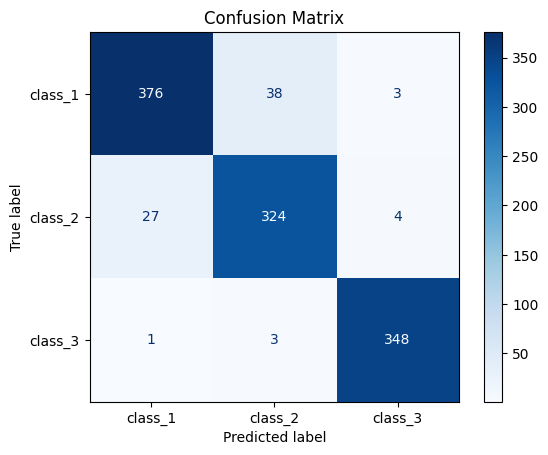

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 自定义数据集类：假定数据集目录下每个子文件夹对应一个类别
class EnhancedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # 按文件夹名称排序得到类别列表
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    img_path = os.path.join(cls_path, img_name)
                    images.append((img_path, self.class_to_idx[cls]))
        print(f"共加载 {len(images)} 张图片，共 {len(self.classes)} 个类别。")
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def train():
    # 判断是否可用 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备：{device}")

    # 数据预处理：调整图片大小为 224x224，并进行数据增强
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 增大
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.GaussianBlur(5),
        transforms.RandomHorizontalFlip(),
    ])

    # 创建数据集（请确认路径正确）
    dataset = EnhancedDataset(root_dir=r"L:\常惠林\萎凋\自然萎凋\分类", transform=transform)
    total_size = len(dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    print(f"训练集：{train_size}，验证集：{val_size}，测试集：{test_size}")

    # 数据加载器
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    # 加载在 ImageNet 上预训练的 ResNet50 模型
    model = models.resnet50(pretrained=True)
    # 修改最后一层全连接层，适应 3 个类别的分类任务
    num_classes = len(dataset.classes)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    num_epochs = 100  # 训练轮数
    best_val_acc = 0.0  # 记录最佳验证集准确率

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0 
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)

        # 验证阶段
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        val_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # 保存验证集上表现最好的模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet50.pth")
            print("保存最佳模型！")

    # 测试阶段
    model.load_state_dict(torch.load("best_resnet50.pth", map_location=device))
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 计算混淆矩阵并进行可视化
    cm = confusion_matrix(all_labels, all_preds)
    print("混淆矩阵：")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

if __name__ == "__main__":
    train()


使用设备：cuda
共加载 5616 张图片，共 3 个类别。
训练集：3369，验证集：1123，测试集：1124


c:\Users\enine\anaconda3\envs\changhl\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\enine\anaconda3\envs\changhl\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100] | Train Loss: 1.0727 | Train Acc: 0.4230 | Val Loss: 0.9966 | Val Acc: 0.5111
保存最佳模型！
Epoch [2/100] | Train Loss: 0.9114 | Train Acc: 0.5868 | Val Loss: 0.8782 | Val Acc: 0.5788
保存最佳模型！
Epoch [3/100] | Train Loss: 0.8045 | Train Acc: 0.6245 | Val Loss: 0.7783 | Val Acc: 0.6492
保存最佳模型！
Epoch [4/100] | Train Loss: 0.7183 | Train Acc: 0.6785 | Val Loss: 0.7329 | Val Acc: 0.6474
Epoch [5/100] | Train Loss: 0.6517 | Train Acc: 0.7213 | Val Loss: 0.6953 | Val Acc: 0.6794
保存最佳模型！
Epoch [6/100] | Train Loss: 0.6046 | Train Acc: 0.7435 | Val Loss: 0.6480 | Val Acc: 0.7142
保存最佳模型！
Epoch [7/100] | Train Loss: 0.5464 | Train Acc: 0.7670 | Val Loss: 0.5919 | Val Acc: 0.7507
保存最佳模型！
Epoch [8/100] | Train Loss: 0.4963 | Train Acc: 0.8029 | Val Loss: 0.5513 | Val Acc: 0.7685
保存最佳模型！
Epoch [9/100] | Train Loss: 0.4388 | Train Acc: 0.8210 | Val Loss: 0.5133 | Val Acc: 0.7988
保存最佳模型！
Epoch [10/100] | Train Loss: 0.3858 | Train Acc: 0.8492 | Val Loss: 0.4821 | Val Acc: 0.7952
Epoch [11/100] 

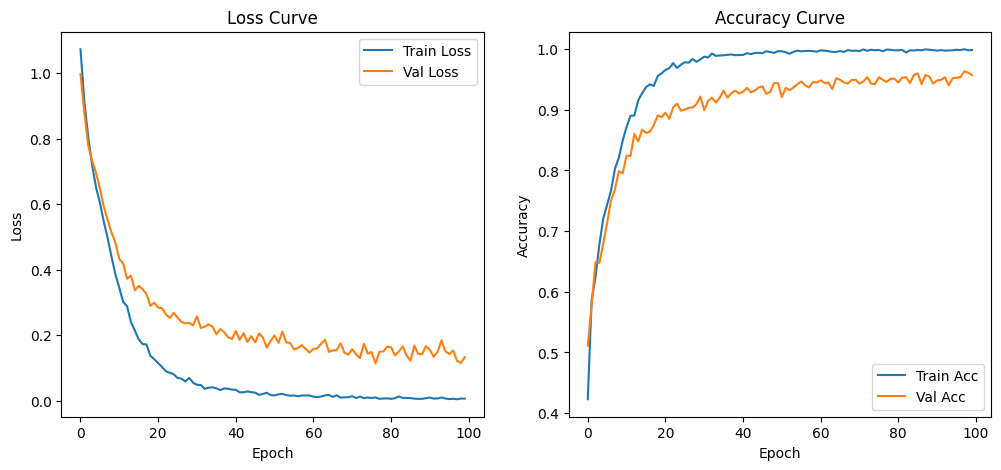

C:\Users\enine\AppData\Local\Temp\ipykernel_4396\3651030295.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet50.pth", map_l

Test Accuracy: 94.57%
混淆矩阵：
[[411  26   0]
 [ 26 325   8]
 [  0   1 327]]


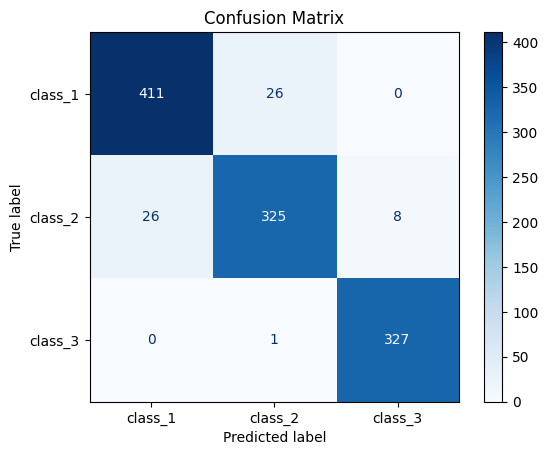

In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 自定义数据集类：假定数据集目录下每个子文件夹对应一个类别
class EnhancedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # 按文件夹名称排序得到类别列表
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            cls_path = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(cls_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    img_path = os.path.join(cls_path, img_name)
                    images.append((img_path, self.class_to_idx[cls]))
        print(f"共加载 {len(images)} 张图片，共 {len(self.classes)} 个类别。")
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def train():
    # 判断是否可用 GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备：{device}")

    # 数据预处理：调整图片大小为 224x224，并进行数据增强
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 增大尺寸
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
        transforms.ToTensor(),
        transforms.GaussianBlur(5),
        transforms.RandomHorizontalFlip(),
    ])

    # 加载数据集（请确认路径正确）
    dataset = EnhancedDataset(root_dir=r"L:\常惠林\萎凋\自然萎凋\分类", transform=transform)
    total_size = len(dataset)
    train_size = int(0.6 * total_size)
    val_size = int(0.2 * total_size)
    test_size = total_size - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    print(f"训练集：{train_size}，验证集：{val_size}，测试集：{test_size}")

    # 创建数据加载器，设置 batch size 为 64
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

    # 加载在 ImageNet 上预训练的 ResNet50 模型
    model = models.resnet50(pretrained=True)
    # 修改最后一层全连接层，适应数据集类别数
    num_classes = len(dataset.classes)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5)

    # 训练配置
    num_epochs = 100
    best_val_acc = 0.0

    # 用于记录训练与验证过程的指标
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total_train += labels.size(0)
        epoch_loss = running_loss / total_train
        epoch_acc = running_correct / total_train
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # 验证阶段
        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_correct += (preds == labels).sum().item()
                total_val += labels.size(0)
        val_loss = val_running_loss / total_val
        val_acc = val_running_correct / total_val
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        
        save_dir = r"L:\常惠林\code\result"
        os.makedirs(save_dir, exist_ok=True)  # 如果目录不存在，则创建目录

        # 保存验证集上表现最好的模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # 拼接保存路径
            save_path = os.path.join(save_dir, "best_resnet50.pth")
            torch.save(model.state_dict(), save_path)
            print(f"保存最佳模型到: {save_path}")

    # 绘制训练/验证曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(val_loss_history, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(val_acc_history, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

    # 测试阶段
    model.load_state_dict(torch.load("best_resnet50.pth", map_location=device))
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")

    # 计算混淆矩阵并显示
    cm = confusion_matrix(all_labels, all_preds)
    print("混淆矩阵：")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

if __name__ == "__main__":
    train()
